<a href="https://colab.research.google.com/github/Martin09/DeepSEM/blob/master/segmentation-NMs/1_nm_seg_image_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NM Segmentation 1: Image Preparation
In this notebook we will:
1. Import our raw SEM images.
2. Filter these based on magnification.
3. Export desired images as PNGs.
3. Upload images for labelling to a new [Labelbox](https://labelbox.com/) project.

In [0]:
# A few useful imports
from matplotlib import pyplot as plt
import shutil, os, random, cv2, tifffile
from pathlib import Path
from google.colab.patches import cv2_imshow

In [0]:
# Define some paths that will be useful later
root = Path('./DeepSEM/segmentation-NMs/')
dataset_dir = root.joinpath('datasets')
github_url = 'https://github.com/Martin09/' + str(root).replace('/','/trunk/')

raw_zip = dataset_dir.joinpath('Nick_NMs_allrawimgs.zip')
raw_dir = dataset_dir.joinpath(raw_zip.stem)
out_dir = dataset_dir.joinpath('Nick_NMs_50kmag_png/')

## 1.1 - Download the dataset

In [77]:
# # Optional: Save everything to your own GoogleDrive
# from google.colab import drive
# drive.mount('/content/gdrive/')
# %cd "/content/gdrive/My Drive/path/to/save/location"

# Clone just a single folder
!rm -rf $root
!apt install subversion
!svn checkout $github_url $root

# # Alternative: Clone whole DeepSEM repository
# !rm -rf DeepSEM  # Remove folder if it already exists
# !git clone https://github.com/Martin09/DeepSEM

Reading package lists... Done
Building dependency tree       
Reading state information... Done
subversion is already the newest version (1.9.7-4ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.
A    DeepSEM/segmentation-NMs/1_nm_seg_image_prep.ipynb
A    DeepSEM/segmentation-NMs/2_nm_seg_training.ipynb
A    DeepSEM/segmentation-NMs/3_nm_seg_inference.ipynb
A    DeepSEM/segmentation-NMs/README.md
A    DeepSEM/segmentation-NMs/datasets
A    DeepSEM/segmentation-NMs/datasets/Nick_NMs_50kmag_png.zip
A    DeepSEM/segmentation-NMs/datasets/export-2020-06-16T09_29_47.338Z.json
A    DeepSEM/segmentation-NMs/trained_models
A    DeepSEM/segmentation-NMs/trained_models/nm_seg_it20k_loss0.029.yaml
Checked out revision 114.


Now we will download ALL the SEM images for the analysis. Since this is a big .zip file, I have to host it on my Google Drive (Github won't let me). Here we will download and unzip the raw SEM images.

In [87]:
# Check if .zip file exists, if not, download it from Google Drive
file_id = '1M2_0GLScsNY53w8hU2xJdXtisESfkOqI'
if raw_zip.exists():
  print('Dataset already exists. Skipping download!')
else:
  print('Dataset does not exist... Downloading!')
  !gdown --id $file_id -O $raw_zip

# Unzip raw dataset
!rm -rf $raw_dir
!unzip -o $raw_zip -d $raw_dir

Dataset already exists. Skipping download!
Archive:  DeepSEM/segmentation-NMs/datasets/Nick_NMs_allrawimgs.zip
   creating: DeepSEM/segmentation-NMs/datasets/Nick_NMs_allrawimgs/6410 NMonSi_MOVPE_w1/
  inflating: DeepSEM/segmentation-NMs/datasets/Nick_NMs_allrawimgs/6410 NMonSi_MOVPE_w1/6410 NMonSi_MOVPE_w1_00.tif  
  inflating: DeepSEM/segmentation-NMs/datasets/Nick_NMs_allrawimgs/6410 NMonSi_MOVPE_w1/6410 NMonSi_MOVPE_w1_01.tif  
  inflating: DeepSEM/segmentation-NMs/datasets/Nick_NMs_allrawimgs/6410 NMonSi_MOVPE_w1/6410 NMonSi_MOVPE_w1_02.tif  
  inflating: DeepSEM/segmentation-NMs/datasets/Nick_NMs_allrawimgs/6410 NMonSi_MOVPE_w1/6410 NMonSi_MOVPE_w1_03.tif  
  inflating: DeepSEM/segmentation-NMs/datasets/Nick_NMs_allrawimgs/6410 NMonSi_MOVPE_w1/6410 NMonSi_MOVPE_w1_04.tif  
  inflating: DeepSEM/segmentation-NMs/datasets/Nick_NMs_allrawimgs/6410 NMonSi_MOVPE_w1/6410 NMonSi_MOVPE_w1_05.tif  
  inflating: DeepSEM/segmentation-NMs/datasets/Nick_NMs_allrawimgs/6410 NMonSi_MOVPE_w1/6410

In [93]:
# Create a list of all TIFF files in the SEM image dataset
in_files = list(raw_dir.rglob('*.tif'))
print("Loaded {:.0f} SEM images.".format(len(in_files)))

Loaded 448 SEM images.


DeepSEM/segmentation-NMs/datasets/Nick_NMs_allrawimgs/6415 NMonSi_MOVPE_w3/6415_NMonSi_MOVPE_w3_75.tif:


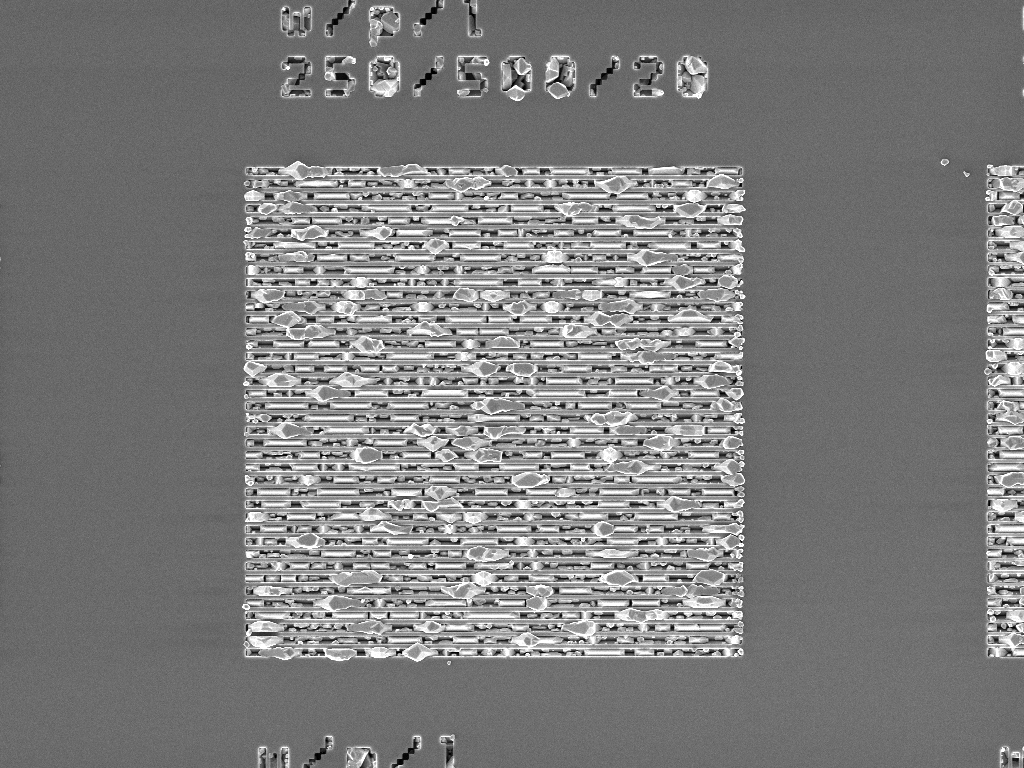

DeepSEM/segmentation-NMs/datasets/Nick_NMs_allrawimgs/6418 NMonSi_MOVPE_w3/6418_NMonSi_MOVPE_w3_59.tif:


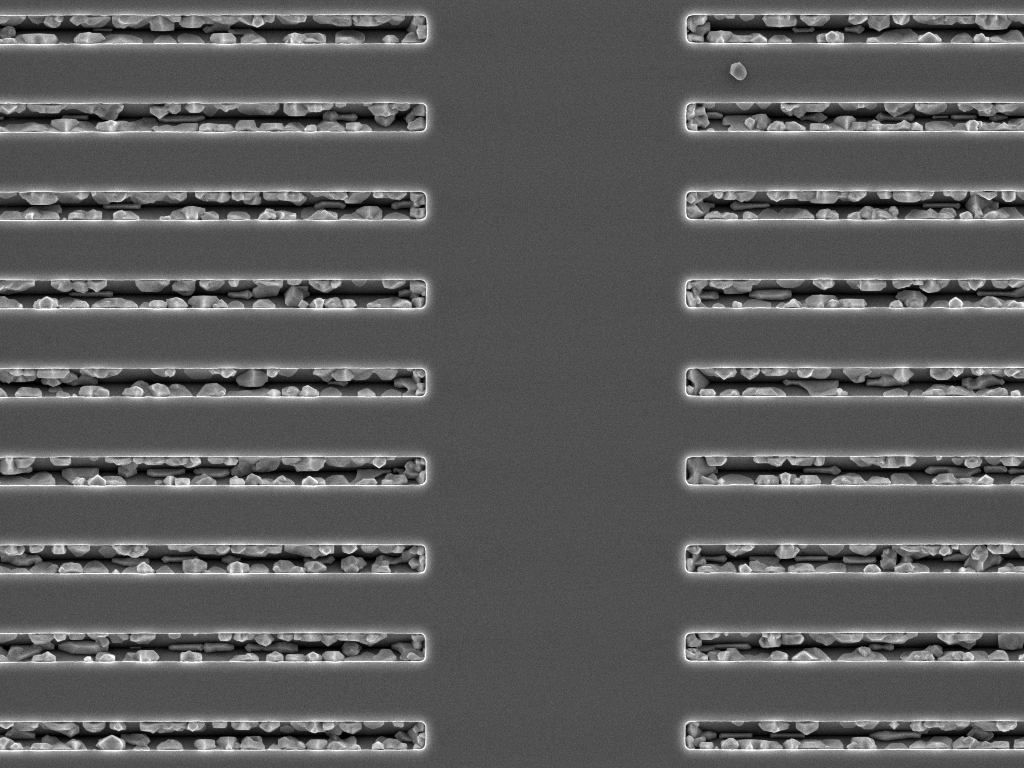

DeepSEM/segmentation-NMs/datasets/Nick_NMs_allrawimgs/6412 NMonSi_MOVPE_w2/6412 NMonSi_MOVPE_w2_09.tif:


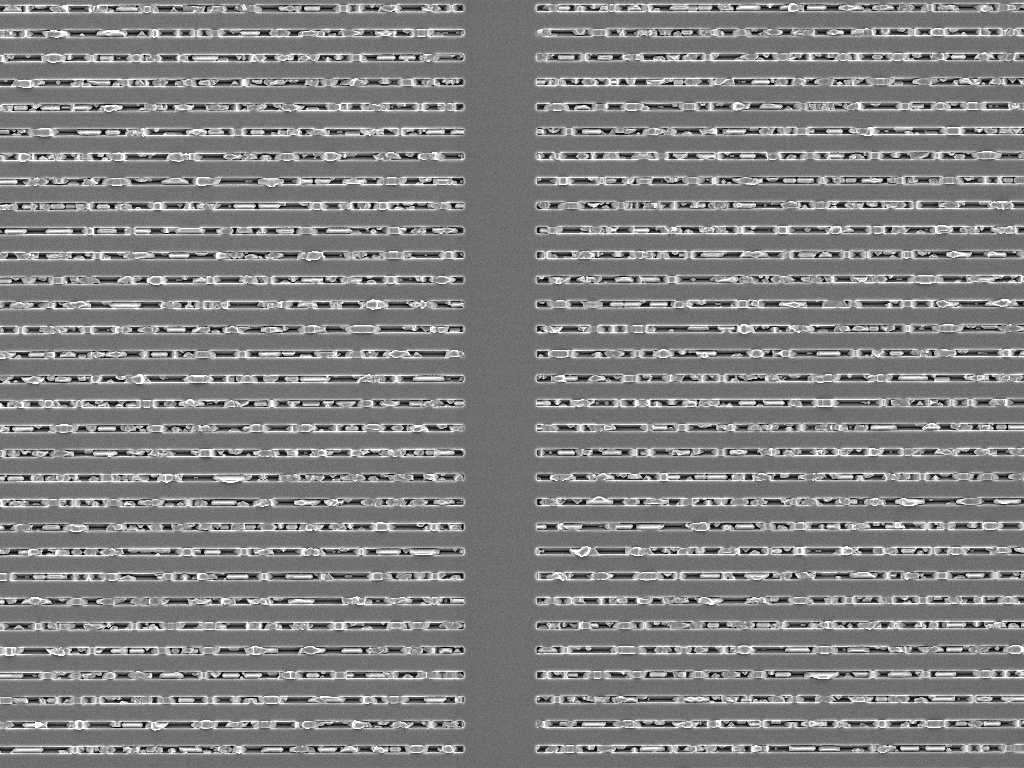

In [108]:
# Sample and display a few of them to see what they look like
for img_file in random.choices(in_files, k=3):
    print(str(img_file) + ":")
    im = cv2.imread(str(img_file), cv2.IMREAD_GRAYSCALE)
    cv2_imshow(im)

Notice the SEM images are of many different magnifications. Should filter these down to a single magnification before building out training set.

## 1.2 - Filtering images by magnification

In [112]:
filtered_imgs = []  # Empty list to save filtered images
mags = []  # Empty list to save magnifications

# Start to loop over all TIFF files
for file in in_files:
    # Open each file using the TiffFile library
    with tifffile.TiffFile(file) as tif:
        
        # Extract magnification data
        mag = tif.sem_metadata['ap_mag'][1] 
        if type(mag) is str:  # Apply correction for "k" ex: mag = "50 k"
            mag = float(mag.split(' ')[0]) * 1000
        else:
            mag = float(mag)

        # Extract pixel size data
        pixel_size = float(tif.sem_metadata['ap_pixel_size'][1])  # nm
        if 'µm' in tif.sem_metadata['ap_pixel_size'][2]: # Correction for um
            pixel_size *= 1000

        # Extract tilt data
        tilt = tif.sem_metadata['ap_tilt_angle'][1] # degrees
#         tilt = tif.sem_metadata['ap_stage_at_t'][1]  # might be equivalent, not sure

    print(f'mag = {mag:6.0f}x, \tpixel_size = {pixel_size:4.0f} nm, \ttilt = {tilt:2.0f}°')
    mags.append(mag)
    
    if mag == 25000:
        filtered_imgs.append(file)

mag =   7000x, 	pixel_size =   40 nm, 	tilt =  0°
mag =   1450x, 	pixel_size =  193 nm, 	tilt =  0°
mag =  25000x, 	pixel_size =   11 nm, 	tilt =  0°
mag =   7000x, 	pixel_size =   40 nm, 	tilt =  0°
mag =   7000x, 	pixel_size =   40 nm, 	tilt =  0°
mag =  25000x, 	pixel_size =   11 nm, 	tilt =  0°
mag =  25000x, 	pixel_size =   11 nm, 	tilt =  0°
mag =   7000x, 	pixel_size =   40 nm, 	tilt =  0°
mag =  25000x, 	pixel_size =   11 nm, 	tilt =  0°
mag =    116x, 	pixel_size = 2412 nm, 	tilt =  0°
mag =  25000x, 	pixel_size =   11 nm, 	tilt =  0°
mag =     76x, 	pixel_size = 3688 nm, 	tilt =  0°
mag =    116x, 	pixel_size = 2412 nm, 	tilt =  0°
mag =    116x, 	pixel_size = 2412 nm, 	tilt =  0°
mag =   1450x, 	pixel_size =  193 nm, 	tilt =  0°
mag =  25000x, 	pixel_size =   11 nm, 	tilt =  0°
mag =   1450x, 	pixel_size =  193 nm, 	tilt =  0°
mag =  25000x, 	pixel_size =   11 nm, 	tilt =  0°
mag =   7000x, 	pixel_size =   40 nm, 	tilt =  0°
mag =   1450x, 	pixel_size =  193 nm, 	tilt =  0°


## 1.2 - Export as PNG
Here we will import the raw TIFF images and export them as PNG files. Since the magnification of these images is relatively high, we only have a a few (<100) objects per image. Thus, we do not need to break the image up into smaller images and we can use the full resolution for training and inference.

In [0]:
import glob, cv2
from google.colab.patches import cv2_imshow
input_files = glob.glob('./DeepSEM/segmentation-NWs/datasets/WJ_NWs_D1-17-02-17-C_rawtiffs/*.tif')

Import a raw TIFF image to see what it looks like.

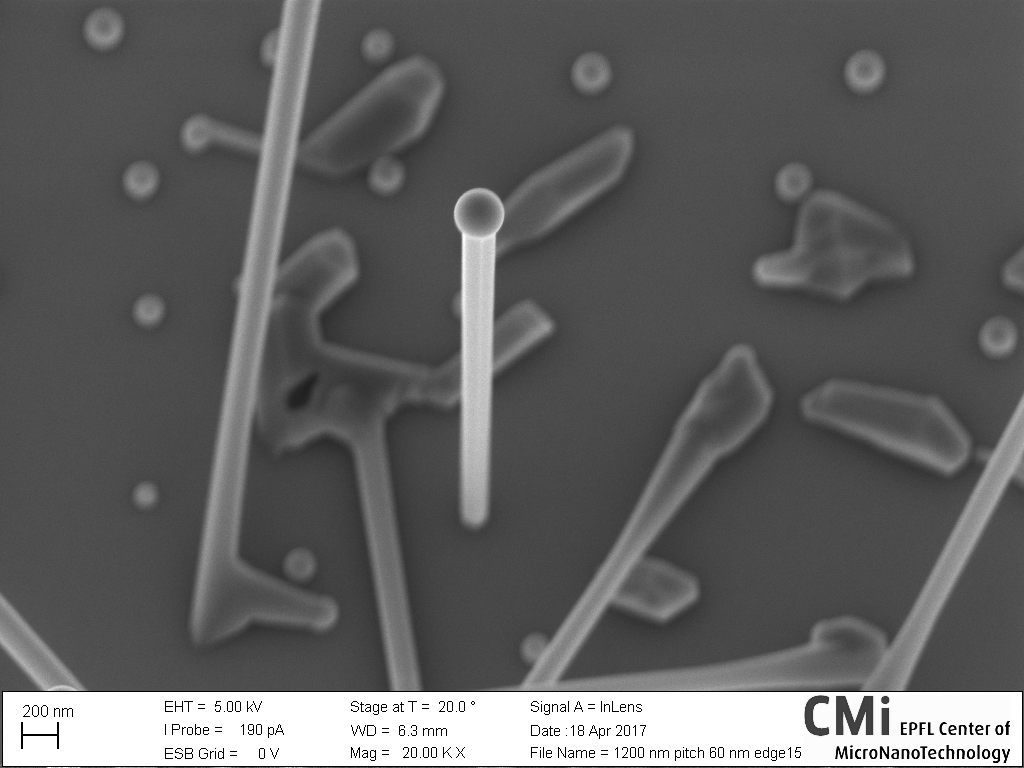

In [0]:
im = cv2.imread(input_files[0], cv2.IMREAD_GRAYSCALE)
cv2_imshow(im)

Loop over all the raw image files and save each as a PNG file.

In [0]:
output_directory = './DeepSEM/segmentation-NWs/datasets/WJ_NWs_D1-17-02-17-C_png/'
!rm -rf $output_directory
!mkdir $output_directory

In [0]:
# Loop over the TIFF files
for file in input_files:
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE) # Import the next image

    # Trim off the overlay bar at bottom of image
    img = img[:688,:]

    # Save as PNG file
    filename = output_directory + file[:-4].split('/')[-1]+'.png'
    print(filename)

    success = cv2.imwrite(filename, (img).astype('uint8')) # Save divided image as PNG

    if not success:
        print("Error, couldn't write image '{}'. Check if output directory exists!".format(filename))

./DeepSEM/segmentation-NWs/datasets/WJ_NWs_D1-17-02-17-C_png/1200 nm pitch 60 nm edge15.png
./DeepSEM/segmentation-NWs/datasets/WJ_NWs_D1-17-02-17-C_png/1400 nm pitch 45 nm edge04.png
./DeepSEM/segmentation-NWs/datasets/WJ_NWs_D1-17-02-17-C_png/1200 nm pitch 60 nm edge17.png
./DeepSEM/segmentation-NWs/datasets/WJ_NWs_D1-17-02-17-C_png/1600 nm pitch 60 nm edge15.png
./DeepSEM/segmentation-NWs/datasets/WJ_NWs_D1-17-02-17-C_png/2000 nm pitch 60 nm edge08.png
./DeepSEM/segmentation-NWs/datasets/WJ_NWs_D1-17-02-17-C_png/1800 nm pitch 60 nm edge26.png
./DeepSEM/segmentation-NWs/datasets/WJ_NWs_D1-17-02-17-C_png/600 nm pitch 45 nm edge02.png
./DeepSEM/segmentation-NWs/datasets/WJ_NWs_D1-17-02-17-C_png/1800 nm pitch 45 nm edge18.png
./DeepSEM/segmentation-NWs/datasets/WJ_NWs_D1-17-02-17-C_png/2000 nm pitch 60 nm edge05.png
./DeepSEM/segmentation-NWs/datasets/WJ_NWs_D1-17-02-17-C_png/800 nm pitch 45 nm center02.png
./DeepSEM/segmentation-NWs/datasets/WJ_NWs_D1-17-02-17-C_png/1400 nm pitch 60 nm

Visualize what an exported PNG image looks like:

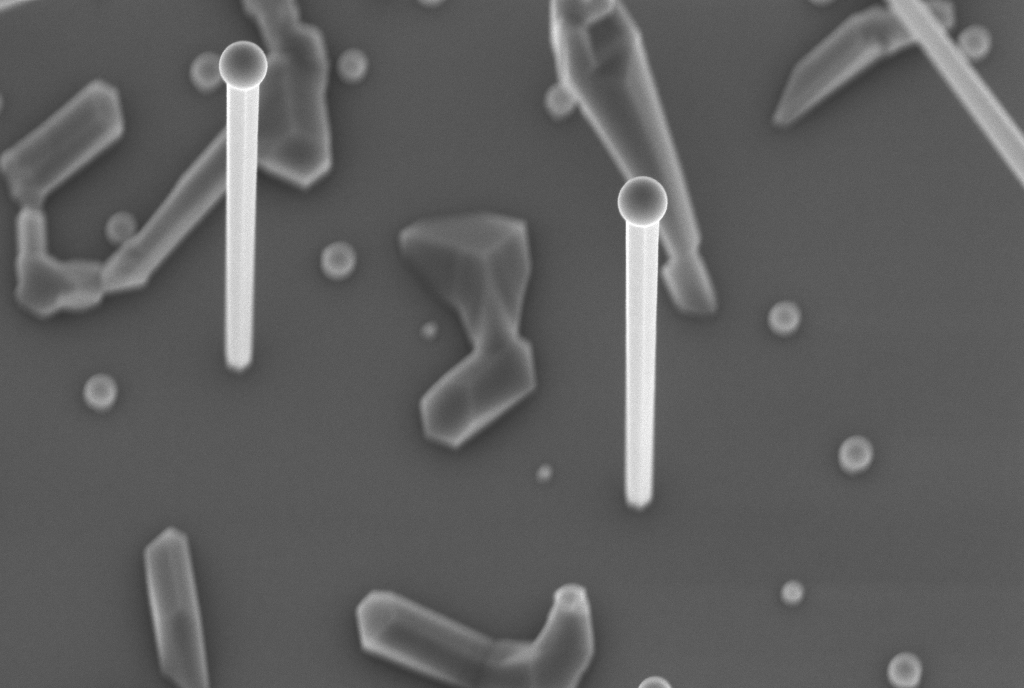

In [0]:
im = cv2.imread('./DeepSEM/segmentation-NWs/datasets/WJ_NWs_D1-17-02-17-C_png/1200 nm pitch 60 nm edge17.png', cv2.IMREAD_GRAYSCALE)
cv2_imshow(im)

## 1.3 - Labelling

Now we are ready to label these images for training the neural network. There are many tools available for creating labelled datasets. In this tutorial I will be using [Labelbox](https://labelbox.com/) for this purpose. 

Note: for those that don't care about labelling their own dataset, you can skip ahead to [Notebook 2](https://colab.research.google.com/github/Martin09/DeepSEM/blob/master/nanowire_yield/2_nw_yield_training.ipynb) where I will provide the pre-labelled data for the next steps.

Moving on, let's install the labelbox API first:

In [0]:
!pip install labelbox

     |████████████████████████████████| 40kB 2.6MB/s 


If you haven't already done so, go ahead and make a free Labelbox account. You can either upload your images to be labelled manually, or you can upload them directly using this script below. 

***If you want to upload the images from this script, you need to create an API key [here](https://app.labelbox.com/account/api-keys) and paste it below:***

In [0]:
API_KEY = '[INSERT LABELBOX API KEY HERE]'

Now we can make a new Labelbox project and a new dataset before uploading the sub-divided images.

In [0]:
# Change these names if you wish
project_name = 'NanowireSegmentation'
dataset_name = 'WJ_NWs_D1-17-02-17-C'

# Create a new project and dataset in Labelbox
from labelbox import Client
client = Client(API_KEY)
project = client.create_project(name=project_name)
dataset = client.create_dataset(name=dataset_name, projects=project)

In [0]:
# Perform a bulk upload of the subdivided PNG files
dataset_dir = './DeepSEM/segmentation-NWs/datasets/WJ_NWs_D1-17-02-17-C_png/'
dataset_files = glob.glob(dataset_dir + '*.png')  # Get a list of the files to upload
dataset.create_data_rows(dataset_files) # Upload the files

<Task ID: ckb98ce4vdtue07161a01ueuu>

After a few minutes, you should see the new project and images appear in your Labelbox account, [here](https://app.labelbox.com/projects). You can now finish setting up your Labelbox project on the website, including setting your object classes.

For this tutorial, we will be doing segmentation. Therefore, be sure to ***only*** define segmentation objects (not bounding box or polygon objects, for example).

[Notebook 2](https://colab.research.google.com/github/Martin09/DeepSEM/blob/master/nanostruct_seg/2_ns_seg_inference.ipynb) assumes you have finished your labelling and have exported a labelbox .JSON file with all of your bounding box labels. If you don't have your own labelled dataset don't worry, I will provide that for you. See you there!